## Social Networks and Recommendation Systems
### Data Science, III semester, 2024Z
Author: Maja Wasielewska

<div style="background-color: lightblue; padding: 50px; text-align: center;">
    <strong>Competition for a community detection method.</strong>

In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import laplacian
from sklearn.cluster import KMeans
import time
import os

In [10]:
#pip install python-louvain

In [11]:
# Function to save results
def save_results(output_path, clusters):
    with open(output_path, 'w') as f:
        for node, cluster in enumerate(clusters, start=1):
            f.write(f"{node},{cluster}\n")
    print(f"Results saved to {output_path}")
    
# Function to draw network with communities
def draw_network_with_communities(graph, labels, title):
    pos = nx.spring_layout(graph) 
    unique_labels = list(set(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels))) # Unique colors for communities

    for label, color in zip(unique_labels, colors):
        nodes = [node for node, community in enumerate(labels) if community == label]
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=[color], label=f"Community {label}")

    nx.draw_networkx_edges(graph, pos, alpha=0.5)

    plt.title(title)
    plt.legend()
    plt.show()

# Spectral Clustering algorithm implementation
def spectral_clustering(adjacency_matrix, n_clusters):
    laplacian_matrix = laplacian(adjacency_matrix, normed=True)
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    k_smallest_eigenvectors = eigenvectors[:, :n_clusters]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(k_smallest_eigenvectors)
    return labels

# Louvain algorithm implementation
def louvain_algorithm(graph):
    def modularity(graph, partition):
        m = graph.size(weight='weight')
        modularity_value = 0
        for community in set(partition.values()):
            nodes = [node for node in partition if partition[node] == community]
            subgraph = graph.subgraph(nodes)
            lc = subgraph.size(weight='weight')
            dc = sum([graph.degree(node, weight='weight') for node in nodes])
            modularity_value += lc / m - (dc / (2 * m)) ** 2
        return modularity_value

    partition = {node: node for node in graph.nodes()}
    best_partition = partition.copy()
    best_modularity = modularity(graph, partition)

    while True:
        for node in graph.nodes():
            best_community = partition[node]
            best_increase = 0
            for neighbor in graph.neighbors(node):
                original_community = partition[node]
                partition[node] = partition[neighbor]
                new_modularity = modularity(graph, partition)
                if new_modularity > best_modularity:
                    best_modularity = new_modularity
                    best_community = partition[neighbor]
                partition[node] = original_community
            partition[node] = best_community

        if partition == best_partition:
            break
        best_partition = partition.copy()
    return best_partition

# KNOWN number of communities case
def detect_known_communities(adjacency_matrix, n_clusters, output_path):
    print("Starting community detection for known number of clusters...")
    start_time = time.time()
    labels = spectral_clustering(adjacency_matrix, n_clusters)
    execution_time = time.time() - start_time
    print(f"----------> Execution time for known clusters: {execution_time:.2f} seconds")
    save_results(output_path, labels)
    graph = nx.from_numpy_array(adjacency_matrix)
    draw_network_with_communities(graph, labels, "KNOWN clusters")
    print("Community detection for known clusters completed! :)\n")
    return execution_time

# UNKNOWN number of communities case
def detect_unknown_communities(adjacency_matrix, output_path):
    print("Starting community detection for unknown number of clusters...")
    graph = nx.from_numpy_array(adjacency_matrix)
    start_time = time.time()
    partition = louvain_algorithm(graph)
    execution_time = time.time() - start_time
    print(f"----------> Execution time for unknown clusters: {execution_time:.2f} seconds")
    
    # Remap community numbers -> 34, 66, 133... to sequential integers
    #labels = [partition[node] for node in graph.nodes()]
    unique_communities = list(set(partition.values()))
    community_mapping = {old: new for new, old in enumerate(unique_communities, start=0)}
    labels = [community_mapping[partition[node]] for node in graph.nodes()]

    save_results(output_path, labels)
    draw_network_with_communities(graph, labels, "UNKNOWN clusters")
    print("Community detection for unknown clusters completed! :)")
    return execution_time

Output directory created: D:\PW3SEM\Social_Networks\competition\competition_results

KNOWN:

Processing dataset with known number of clusters...
Starting community detection for known number of clusters...
----------> Execution time for known clusters: 0.01 seconds
Results saved to D:\PW3SEM\Social_Networks\competition\competition_results\D2-K=7_result.csv


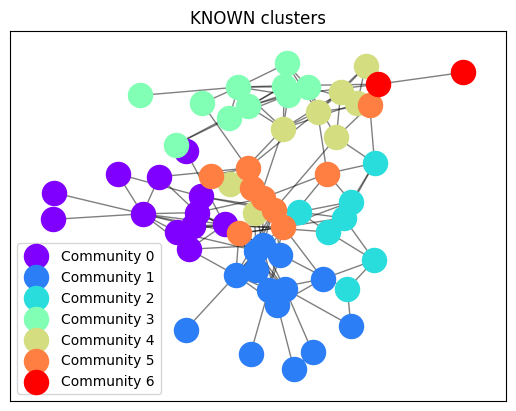

Community detection for known clusters completed! :)

UNKNOWN:

Processing dataset with unknown number of clusters...
Starting community detection for unknown number of clusters...
----------> Execution time for unknown clusters: 28.78 seconds
Results saved to D:\PW3SEM\Social_Networks\competition\competition_results\D2-UNC_result.csv


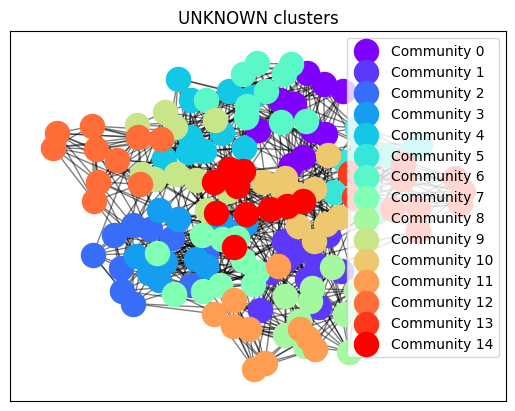

Community detection for unknown clusters completed! :)


In [12]:
# Paths to the input files -> D2-K=7.csv and D2-UNC.csv
file_known_clusters = r"D:\PW3SEM\Social_Networks\competition\D2-K=7.csv"
file_unknown_clusters = r"D:\PW3SEM\Social_Networks\competition\D2-UNC.csv"

# Load datasets
adj_known = pd.read_csv(file_known_clusters, header=None).values
adj_unknown = pd.read_csv(file_unknown_clusters, header=None).values

# Output directory
output_dir = r"D:\PW3SEM\Social_Networks\competition\competition_results"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created: {output_dir}\n")

# Detect communities for the KNOWN case
print("KNOWN:\n\nProcessing dataset with known number of clusters...")
known_execution_time = detect_known_communities(adj_known, n_clusters=7, output_path=os.path.join(output_dir, "D2-K=7_result.csv"))

# Detect communities for the UNKNOWN case
print("UNKNOWN:\n\nProcessing dataset with unknown number of clusters...")
unknown_execution_time = detect_unknown_communities(adj_unknown, output_path=os.path.join(output_dir, "D2-UNC_result.csv"))

# Description file
authors = "Maja Wasielewska"
description_path = os.path.join(output_dir, "description.txt")
with open(description_path, 'w') as f:
    f.write(f"{authors}\n")
    f.write(f"D2-K=7_result.csv,{known_execution_time}\n")
    f.write(f"D2-UNC_result.csv,{unknown_execution_time}\n")
    # Add GitHub link repository